# Imports

In [1]:
sys.path.append('/home/spike/') #path to the ecogy package

In [105]:
from ecogy.io import LinearProbe, FilmProbe, Reader
from ecogy.io import get_time_slice, get_raw, get_events
from ecogy.io import remove_artifact
import copy

# Preprocess data

## Probe

In [3]:
ls /home/spike/ecogy/probes

A1x16_100um.csv  XA60_FILM_IB1_IB2.csv  XA60_FILM_IB2_IB3.csv
A1x16_50um.csv   XA60_FILM_IB1_IB3.csv


In [ ]:
df = pd.read_csv('/home/spike/ecogy/probes/XA60_FILM_IB2_IB3.csv', index_col=0)
fp = FilmProbe(df)
fp.show()

<IPython.core.display.Javascript object>


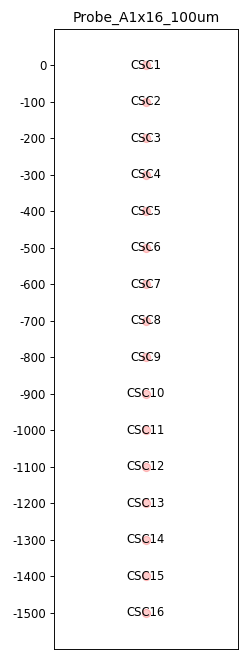

In [80]:
df = pd.read_csv('/home/spike/ecogy/probes/A1x16_100um.csv', index_col=0)
p = LinearProbe(df)
p.show()

## Data

### Path

In [ ]:
rec = '2019-07-27_00-32-17'
exp = rec[:10]
year = rec[:4]
# exp = '2019-10-14'

In [ ]:
# os.listdir()

In [5]:
path = '/media/data/AUD2/2019-07-28_00-39-07/'

In [ ]:
path = f'/home/spike/mounts/R_KHZPV_7322/CheetahData3/Roman/{year}/{exp}/{rec}/'
assert path[-1] == '/'
path

### Reader

In [6]:
reader = Reader(path)
reader.info()

Total number of channels       : 16
    Number of CSC channels     : 16


Sampling frequency             : 32000 Hz

Block 0 has:                  
    Segment 0 of length        : 188.416 s ( 3.1402666666666668 )min


### Parameters

In [87]:
block_index, seg_index = 0, 0

t_start , t_stop = None, None

t_start, t_stop = get_time_slice(reader, t_start, t_stop, block_index, seg_index)

Starts at                      : 0.0 s
Stops at                       : 188.4159240000008 s


### Raw

In [8]:
raw = get_raw(reader,
              selected_channels = p.channels, 
              block_index=block_index, 
              seg_index=seg_index, 
              t_start=t_start, 
              t_stop=t_stop)

time = np.linspace(t_start, 
                   raw.get_data().shape[1]/raw.info['sfreq'] + t_stop, 
                   raw.get_data().shape[1])

print(f'Raw signal has shape {raw.get_data().shape}')

Raw signal has shape (16, 6029309)


<IPython.core.display.Javascript object>


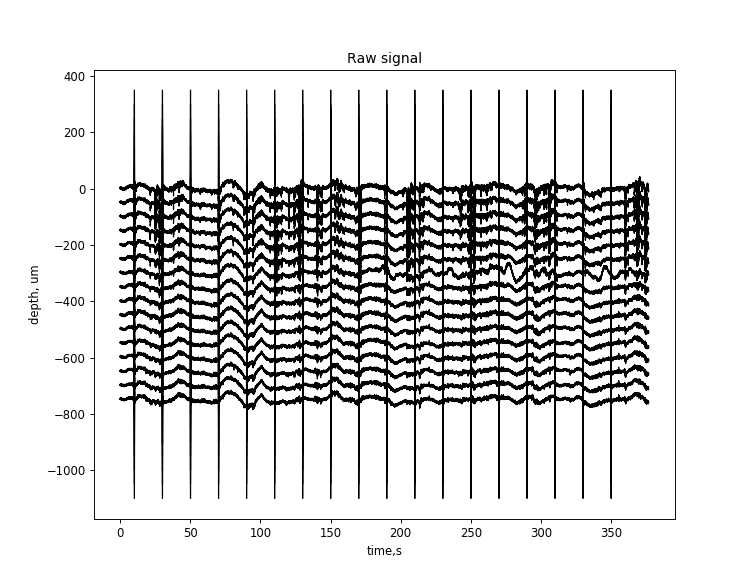

Text(0, 0.5, 'depth, um')

In [9]:
plt.figure(figsize=[9,7])

plt.plot(time, raw.get_data().T/10 + p.y, 'k', lw=1);
plt.title('Raw signal')
plt.xlabel('time,s')
plt.ylabel('depth, um')

### LFP

In [10]:
lfp = raw.copy().filter(0,1000).resample(1000)

time_lfp = np.linspace(t_start, 
                   lfp.get_data().shape[1]/lfp.info['sfreq'] + t_stop, 
                   lfp.get_data().shape[1])

<IPython.core.display.Javascript object>


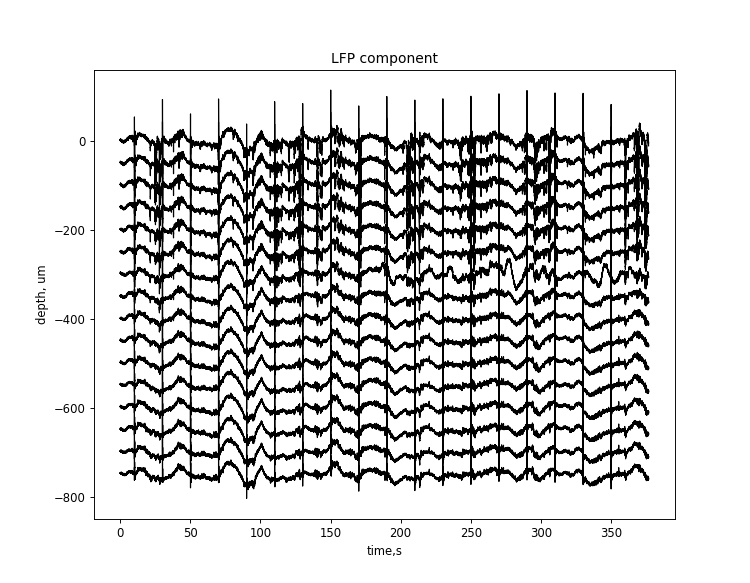

Text(0, 0.5, 'depth, um')

In [11]:
plt.figure(figsize=[9,7])

plt.plot(time_lfp, lfp.get_data().T/10 + p.y, 'k', lw=1);
plt.title('LFP component')
plt.xlabel('time,s')
plt.ylabel('depth, um')

## Events

### Electric

In [13]:
df_ev = get_events(reader, 
                   block_index=block_index, 
                   seg_index=seg_index, 
                   t_start=t_start, 
                   t_stop=t_stop)

Events event_id=11 ttl=0 18
Events event_id=11 ttl=1 18
Events event_id=19 ttl=0 1


In [16]:
df_ev = df_ev[df_ev['ttl']!=0]

,event_id,ttl,time,ts
1,11,1,5.08376,162680
3,11,1,15.0822,482631
5,11,1,25.0807,802583
7,11,1,35.0792,1122534
9,11,1,45.0777,1442485
11,11,1,55.0761,1762436
13,11,1,65.0746,2082388
15,11,1,75.0731,2402339
17,11,1,85.0715,2722289
19,11,1,95.07,3042240


In [51]:
ts = df_ev['ts'].to_numpy()

In [56]:
events = np.array((ts, np.zeros_like(ts), np.zeros_like(ts))).T.astype(int)
events

array([[ 162680,       0,       0],
       [ 482631,       0,       0],
       [ 802583,       0,       0],
       [1122534,       0,       0],
       [1442485,       0,       0],
       [1762436,       0,       0],
       [2082388,       0,       0],
       [2402339,       0,       0],
       [2722289,       0,       0],
       [3042240,       0,       0],
       [3362192,       0,       0],
       [3682143,       0,       0],
       [4002094,       0,       0],
       [4322045,       0,       0],
       [4641997,       0,       0],
       [4961947,       0,       0],
       [5281898,       0,       0],
       [5601849,       0,       0]])

### PZO

## Epochs

In [89]:
epochs = mne.Epochs(raw,
                    events,
                    preload=True,
                    tmin = -0.5,
                    tmax = 1.0 - 1/raw.info['sfreq']) #to avoide odd length
epochs.get_data().shape

(18, 16, 48000)

<IPython.core.display.Javascript object>


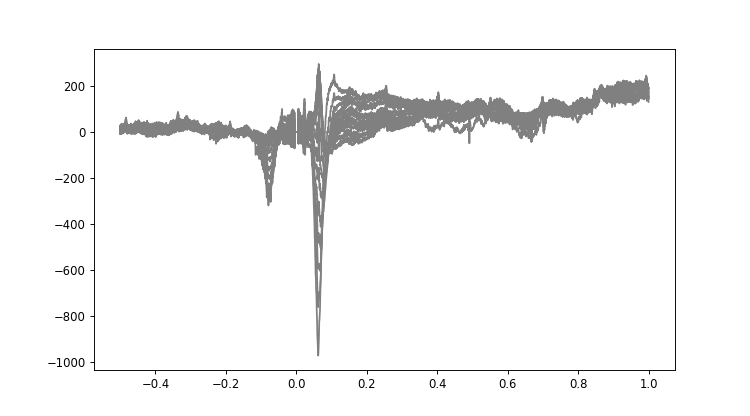

In [101]:
plt.figure(figsize=[9,5])
ttt = np.linspace(-0.5, 1, epochs.get_data().shape[2])
plt.plot(ttt, epochs.get_data()[3,:,:].T, 'gray');

In [91]:
epochs.filter(0,2000).resample(2000)

<Epochs  |   18 events (all good), -0.5 - 0.9995 sec, baseline [None, 0], ~6.6 MB, data loaded,
 '0': 18>

In [104]:
zero_artifact(epochs)

In [97]:
epochs.reorder_channels(p.channels)
epochs.ch_names

<Epochs  |   18 events (all good), -0.5 - 0.9995 sec, baseline [None, 0], ~6.6 MB, data loaded,
 '0': 18>

In [ ]:
# dead
# noisy

# Save as .pkl